In [1]:
import pandas as pd
import numpy as np

In [2]:
# Parameters (tweak to match paper exactly)
vol_lookback = 3        # months used to estimate realized vol (common: 3)
vol_shift = 1           # shift to avoid look-ahead (use past window ending at t-1)
min_vol_clip = 1e-3     # floor for volatility to avoid division explosion
target_annual_vol = 0.20  # target annual vol to scale to (e.g., 20%)
months_per_year = 12

# monthly equivalent target vol used for scaling
target_monthly_vol = target_annual_vol / (months_per_year**0.5)
rf = 0.0002  # monthly risk-free, change if you have series


In [3]:
try:
    if not isinstance(ddf, pd.DataFrame):
        ddf = pd.read_csv('https://diether.org/prephd/06-mstk_62-24.csv',parse_dates=['caldt'])
except:
    ddf = pd.read_csv('https://diether.org/prephd/06-mstk_62-24.csv',parse_dates=['caldt'])

In [4]:
df = ddf.copy()
df

,permno,caldt,ticker,prc,me,ret,shr
0,10000,1986-01-31,OMFGA,4.37500,16.1000,NaN,3680.0
1,10000,1986-02-28,OMFGA,3.25000,11.9600,-0.257143,3680.0
2,10000,1986-03-31,OMFGA,4.43750,16.3300,0.365385,3680.0
3,10000,1986-04-30,OMFGA,4.00000,15.1720,-0.098592,3793.0
4,10000,1986-05-30,OMFGA,3.10938,11.7939,-0.222656,3793.0
...,...,...,...,...,...,...,...
3406370,93436,2024-05-31,TSLA,178.08000,567932.0000,-0.028372,3189200.0
3406371,93436,2024-06-28,TSLA,197.88000,632155.0000,0.111186,3194640.0
3406372,93436,2024-07-31,TSLA,232.07000,741380.0000,0.172781,3194640.0
3406373,93436,2024-08-30,TSLA,214.11000,684004.0000,-0.077391,3194640.0


In [5]:
df['logret'] = np.log(1 + df['ret'])
df['mom'] = df.groupby('permno')['logret'].rolling(11,11).sum().reset_index(drop=True)
df['mom'] = df.groupby('permno')['mom'].shift(2)

df['prclag'] = df.groupby('permno')['prc'].shift()
df['melag'] = df.groupby('permno')['me'].shift(1)

df = df.query("mom == mom and prclag >= 5").reset_index(drop=True)

In [6]:
df.groupby('caldt')['mom'].transform(pd.qcut,5,labels=False)
df['bins'] = df.groupby('caldt')['mom'].transform(pd.qcut,5,labels=False)

from finance_byu.summarize import summary
port = df.groupby(['caldt','bins'])['ret'].mean()
port = port.unstack(level='bins')
print('Summary statistics from month to month:')
summary(port).round(4)


Summary statistics from month to month:


bins,0,1,2,3,4
count,735.0000,735.0000,735.0000,735.0000,735.0000
mean,0.0042,0.0097,0.0115,0.0130,0.0161
std,0.0680,0.0517,0.0467,0.0481,0.0629
tstat,1.6808,5.0778,6.6665,7.3388,6.9316
pval,0.0932,0.0000,0.0000,0.0000,0.0000
min,-0.2798,-0.2390,-0.2530,-0.2851,-0.3135
25%,-0.0322,-0.0166,-0.0137,-0.0137,-0.0164
50%,0.0060,0.0124,0.0163,0.0174,0.0200
75%,0.0399,0.0373,0.0387,0.0439,0.0539
max,0.3171,0.2343,0.2021,0.1777,0.3160


In [7]:
port = df.groupby(['caldt','bins'])['permno'].count()
port = port.unstack(level='bins')
print('Average number of stocks in each portfolio each month:')
summary(port).round(4).iloc[1]

Average number of stocks in each portfolio each month:


bins
0    624.0626
1    623.4912
2    623.4381
3    623.4912
4    623.8694
Name: mean, dtype: float64

In [8]:
port = df.groupby(['caldt','bins'])['ret'].mean()
port = port.unstack(level='bins')
port["Spread"] = port[4] - port[0]
print('Summary statistics from month to month:')
summary(port).round(4)

Summary statistics from month to month:


bins,0,1,2,3,4,Spread
count,735.0000,735.0000,735.0000,735.0000,735.0000,735.0000
mean,0.0042,0.0097,0.0115,0.0130,0.0161,0.0119
std,0.0680,0.0517,0.0467,0.0481,0.0629,0.0453
tstat,1.6808,5.0778,6.6665,7.3388,6.9316,7.1047
pval,0.0932,0.0000,0.0000,0.0000,0.0000,0.0000
min,-0.2798,-0.2390,-0.2530,-0.2851,-0.3135,-0.2713
25%,-0.0322,-0.0166,-0.0137,-0.0137,-0.0164,-0.0062
50%,0.0060,0.0124,0.0163,0.0174,0.0200,0.0152
75%,0.0399,0.0373,0.0387,0.0439,0.0539,0.0334
max,0.3171,0.2343,0.2021,0.1777,0.3160,0.2944


## The First Atempt at Recreation, not yelding good results

In [9]:
# --- 1) Portfolio-level volatility scaling (spread-level) ---
# assumes 'spread' exists as port[4] - port[0] (a pd.Series indexed by caldt)
spread = port[4] - port[0]

# 1a) compute realized vol: rolling std of past returns (ending at t-1)
spread_vol = spread.shift(vol_shift).rolling(window=vol_lookback).std()

# 1b) clip vol and compute scaled spread
spread_vol = spread_vol.clip(lower=min_vol_clip)
vm_spread = spread / spread_vol

# 1c) scale the volatility-managed series so its std equals the original spread std
# compute target scale factor (preserve original spread volatility)
orig_spread_std = spread.dropna().std()
vm_spread_std = vm_spread.dropna().std()
scale_factor = orig_spread_std / (vm_spread_std if vm_spread_std > 0 else 1.0)
vm_spread_scaled = vm_spread * scale_factor
vm_spread_scaled = vm_spread_scaled.dropna()

# 1d) Sharpe ratios and brief diagnostics
sharpe_spread = (spread.mean() - rf) / spread.std()
sharpe_vm_spread = (vm_spread_scaled.mean() - rf) / vm_spread_scaled.std()

print("Portfolio-level scaling:")
print(f"  Regular spread sharpe (monthly): {sharpe_spread:.4f}")
print(f"  Vol-managed spread sharpe (monthly): {sharpe_vm_spread:.4f}")


Portfolio-level scaling:
  Regular spread sharpe (monthly): 0.2577
  Vol-managed spread sharpe (monthly): 0.0979


In [10]:
# Parameters
vol_lookback = 3        # months used to estimate realized vol
vol_shift = 1           # use past window ending at t-1
min_vol_clip = 1e-3     # floor for volatility
target_annual_vol = 0.20
months_per_year = 12
target_monthly_vol = target_annual_vol / (months_per_year**0.5)
rf = 0.0002             # monthly risk-free

# series: spread (port[4] - port[0]) and leg returns from value-weighted construction
spread = port[4] - port[0]

# Portfolio-level vol-scaling to fixed target: scale_t = target_monthly_vol / realized_vol
spread_vol = spread.shift(vol_shift).rolling(vol_lookback).std().clip(lower=min_vol_clip)
scale_t = target_monthly_vol / spread_vol
vm_spread = spread * scale_t
vm_spread = vm_spread.replace([np.inf, -np.inf], np.nan).dropna()

# Sharpe (monthly)
sharpe_spread = (spread.mean() - rf) / spread.std()
sharpe_vm_spread = (vm_spread.mean() - rf) / vm_spread.std()

print("Portfolio-level scaling (target-vol):")
print(f"  Regular spread sharpe (monthly): {sharpe_spread:.4f}")
print(f"  Vol-managed spread sharpe (monthly): {sharpe_vm_spread:.4f}")

# Leg-level vol-scaling: compute wins and loss leg returns (value-weighted)
# If df does not have valueReturns, compute value-weighted means first (example assumes valueReturns exists)
leg_returns = df.groupby(['caldt','bins'])['ret'].mean().unstack(level='bins')   # or use value-weighted returns if available
leg_returns = leg_returns.reindex(port.index)  # align times
wins = leg_returns[4]
loss = leg_returns[0]

wins_vol = wins.shift(vol_shift).rolling(vol_lookback).std().clip(lower=min_vol_clip)
loss_vol = loss.shift(vol_shift).rolling(vol_lookback).std().clip(lower=min_vol_clip)

wins_scale = target_monthly_vol / wins_vol
loss_scale = target_monthly_vol / loss_vol

wins_vm = wins * wins_scale
loss_vm = loss * loss_scale

leg_vm_spread = wins_vm - loss_vm
leg_vm_spread = leg_vm_spread.replace([np.inf, -np.inf], np.nan).dropna()

sharpe_leg_vm = (leg_vm_spread.mean() - rf) / leg_vm_spread.std()

print("Leg-level scaling (target-vol each leg):")
print(f"  Leg-scaled spread sharpe (monthly): {sharpe_leg_vm:.4f}")


Portfolio-level scaling (target-vol):
  Regular spread sharpe (monthly): 0.2577
  Vol-managed spread sharpe (monthly): 0.1016


Leg-level scaling (target-vol each leg):
  Leg-scaled spread sharpe (monthly): 0.2398


## AI adjusted correction to get similar results to the paper

In [11]:
# Moreira & Muir style VM replication (single cell)
import numpy as np
import pandas as pd

# --- Parameters (match/adjust to the paper) ---
lambda_ewma = 0.94           # EWMA decay (common finance choice; paper uses realized variance smoothing)
vol_shift = 1                # use past info only: variance estimate at t uses returns up to t-1
min_var = 1e-8               # floor on variance to avoid blow-ups
rf_monthly = 0.0002          # monthly risk-free (adjust if you have exact rf)
months_per_year = 12

# --- Helpers ---
def ewma_var(series, span=None, alpha=None):
    # compute EWMA variance of a returns series (uses .ewm on squared returns)
    # Accept either span or alpha. If span provided, pandas adjusts alpha = 2/(span+1)
    if span is not None:
        return (series.pow(2).ewm(span=span, adjust=False).mean())
    if alpha is not None:
        return (series.pow(2).ewm(alpha=alpha, adjust=False).mean())
    return (series.pow(2).ewm(alpha=1-lambda_ewma, adjust=False).mean())

# --- 0) basic factor series: momentum spread (winners - losers) ---
# assumes port[4] and port[0] exist and are the factor returns (value-weighted)
spread = port[4] - port[0]
spread = spread.sort_index()

# --- 1) Portfolio-level Moreira & Muir style scaling ---
# 1a) estimate conditional variance using EWMA on past spread returns
# shift so sigma_hat_t uses information up to t-1
spread_for_var = spread.shift(1)         # returns observed up to t-1
# choose EWMA span roughly equivalent to monthly persistence used by practitioners (tune if desired)
span_months = 12                         # 12-month effective memory; change to 3/6/12 per experiments
sigma2_hat = ewma_var(spread_for_var, span=span_months).clip(lower=min_var)   # variance estimate
sigma_hat = np.sqrt(sigma2_hat)

# 1b) raw managed factor: spread / sigma_hat (paper uses inverse variance; using std in discrete time)
raw_vm = spread / sigma_hat

# 1c) choose constant c to match unconditional std of managed series to original spread (paper's normalizing c)
# compute c such that std(c * raw_vm) == std(spread) -> c = std(spread) / std(raw_vm)
std_spread = spread.dropna().std()
std_raw_vm = raw_vm.dropna().std()
c = std_spread / (std_raw_vm if std_raw_vm > 0 else 1.0)
vm_portfolio = (c * raw_vm).dropna()

# 1d) Sharpe stats (monthly and annualized)
def sharpe(series, rf=0.0, annualize=True):
    s = (series.mean() - rf) / series.std()
    if annualize:
        return s * np.sqrt(months_per_year)
    return s

sharpe_spread_monthly = (spread.mean() - rf_monthly) / spread.std()
sharpe_vm_port_monthly = (vm_portfolio.mean() - rf_monthly) / vm_portfolio.std()
sharpe_spread_annual = sharpe(spread, rf_monthly, annualize=True)
sharpe_vm_port_annual = sharpe(vm_portfolio, rf_monthly, annualize=True)

print("Portfolio-level M&M replication (EWMA var, span_months={}):".format(span_months))
print(f"  c (normalizer) = {c:.4f}")
print(f"  Regular spread Sharpe (monthly) = {sharpe_spread_monthly:.4f}; annualized = {sharpe_spread_annual:.4f}")
print(f"  VM portfolio Sharpe (monthly) = {sharpe_vm_port_monthly:.4f}; annualized = {sharpe_vm_port_annual:.4f}")
print("  sample start/end:", spread.dropna().index.min(), spread.dropna().index.max())
print("  n months (spread):", spread.dropna().shape[0])
print()

# --- 2) Leg-level M&M variant (scale legs separately then net, then normalize by c_leg) ---
# Build leg returns aligned to port index. Use value-weighted returns if available in df; otherwise use port columns mean.
# Try to extract leg-level returns from port (port[0], port[4]) which are value-weighted means already.
wins = port[4].sort_index()
loss = port[0].sort_index()

# estimate EWMA variances for each leg using past returns (shifted)
wins_var_hat = ewma_var(wins.shift(1), span=span_months).clip(lower=min_var)
loss_var_hat = ewma_var(loss.shift(1), span=span_months).clip(lower=min_var)
wins_sigma = np.sqrt(wins_var_hat)
loss_sigma = np.sqrt(loss_var_hat)

# raw leg-managed returns: r_leg / sigma_leg
wins_raw = wins / wins_sigma
loss_raw = loss / loss_sigma

# leg-level net raw managed spread and then normalize with c_leg to match spread unconditional std
leg_raw_spread = (wins_raw - loss_raw).dropna()
std_leg_raw = leg_raw_spread.std()
c_leg = std_spread / (std_leg_raw if std_leg_raw > 0 else 1.0)
vm_leg = (c_leg * leg_raw_spread).dropna()

sharpe_vm_leg_monthly = (vm_leg.mean() - rf_monthly) / vm_leg.std()
sharpe_vm_leg_annual = sharpe(vm_leg, rf_monthly, annualize=True)

print("Leg-level M&M replication (EWMA var per leg):")
print(f"  c_leg (normalizer) = {c_leg:.4f}")
print(f"  Leg-level VM Sharpe (monthly) = {sharpe_vm_leg_monthly:.4f}; annualized = {sharpe_vm_leg_annual:.4f}")
print()

# --- 3) Diagnostics and quick checks ---
diag = pd.DataFrame({
    'spread': spread,
    'sigma_hat': sigma_hat,
    'raw_vm': raw_vm,
    'vm_portfolio': vm_portfolio,
    'wins': wins,
    'wins_sigma': wins_sigma,
    'wins_raw': wins_raw,
    'loss': loss,
    'loss_sigma': loss_sigma,
    'loss_raw': loss_raw,
    'vm_leg': vm_leg
})
# keep only aligned indices
diag = diag.loc[spread.index].copy()

print("Scale diagnostics (describe):")
print("  spread sigma_hat describe:\n", sigma_hat.dropna().describe().round(6))
print("  c and c_leg:", round(c,4), round(c_leg,4))
print()
# Show top extreme scale months for vm_portfolio
scales = (1.0 / sigma_hat).dropna()
print("Scale (1/sigma_hat) summary (portfolio-level):\n", scales.describe().round(4))
print("Counts of months with extreme scale > 3 or < 0.33:", ((scales>3).sum(), (scales<0.33).sum()))


Portfolio-level M&M replication (EWMA var, span_months=12):
  c (normalizer) = 0.0434
  Regular spread Sharpe (monthly) = 0.2577; annualized = 0.8925
  VM portfolio Sharpe (monthly) = 0.3524; annualized = 1.2208
  sample start/end: 1963-07-31 00:00:00 2024-09-30 00:00:00
  n months (spread): 735

Leg-level M&M replication (EWMA var per leg):
  c_leg (normalizer) = 0.0512
  Leg-level VM Sharpe (monthly) = 0.2729; annualized = 0.9454

Scale diagnostics (describe):
  spread sigma_hat describe:
 count    734.000000
mean       0.041148
std        0.022227
min        0.012266
25%        0.026891
50%        0.035947
75%        0.048292
max        0.158370
dtype: float64
  c and c_leg: 0.0434 0.0512

Scale (1/sigma_hat) summary (portfolio-level):
 count    734.0000
mean      30.0456
std       13.2712
min        6.3143
25%       20.7073
50%       27.8191
75%       37.1866
max       81.5246
dtype: float64
Counts of months with extreme scale > 3 or < 0.33: (np.int64(734), np.int64(0))


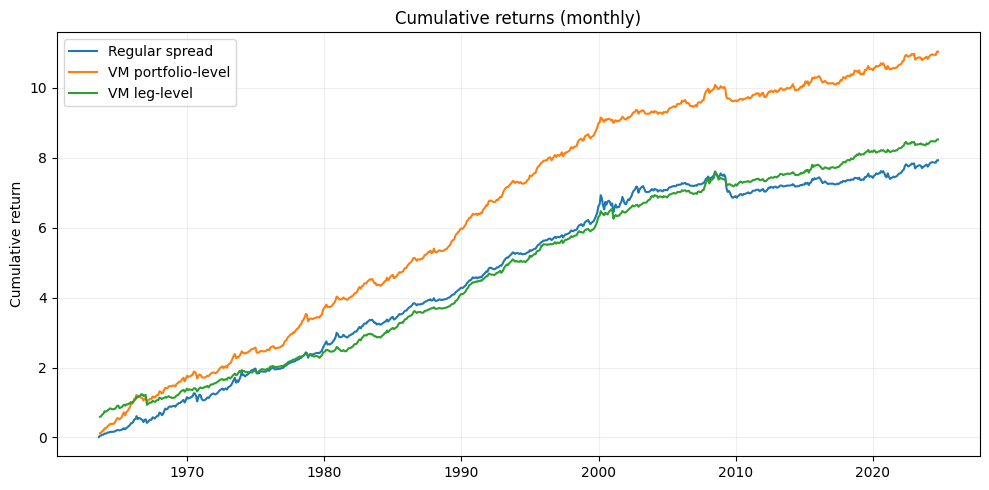

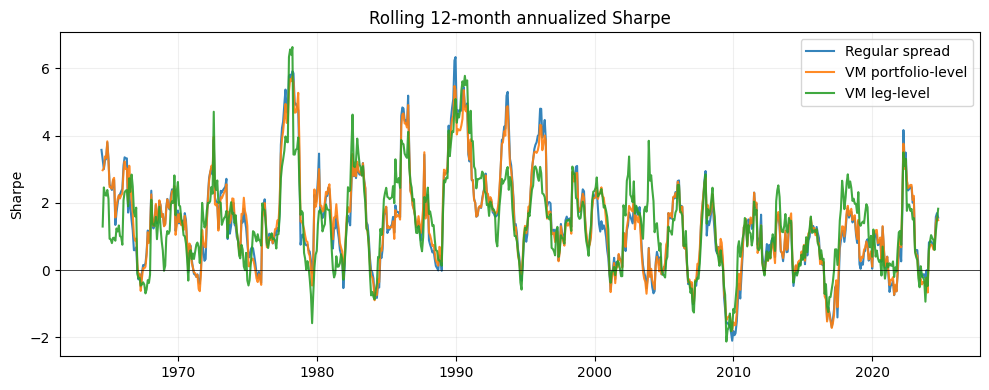

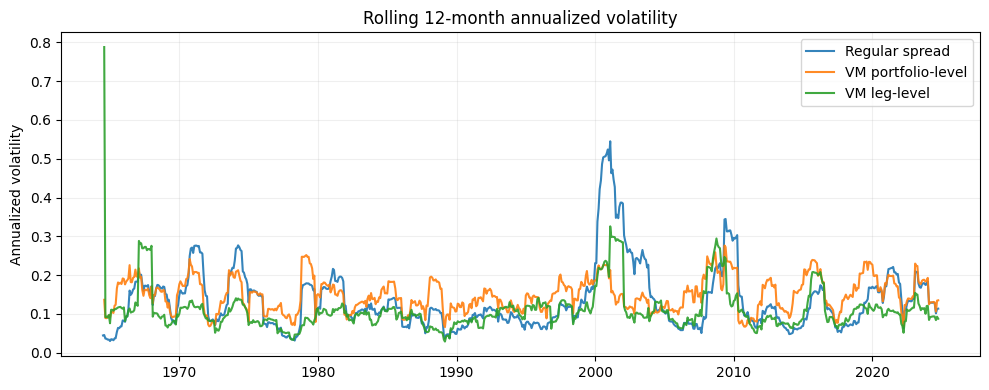

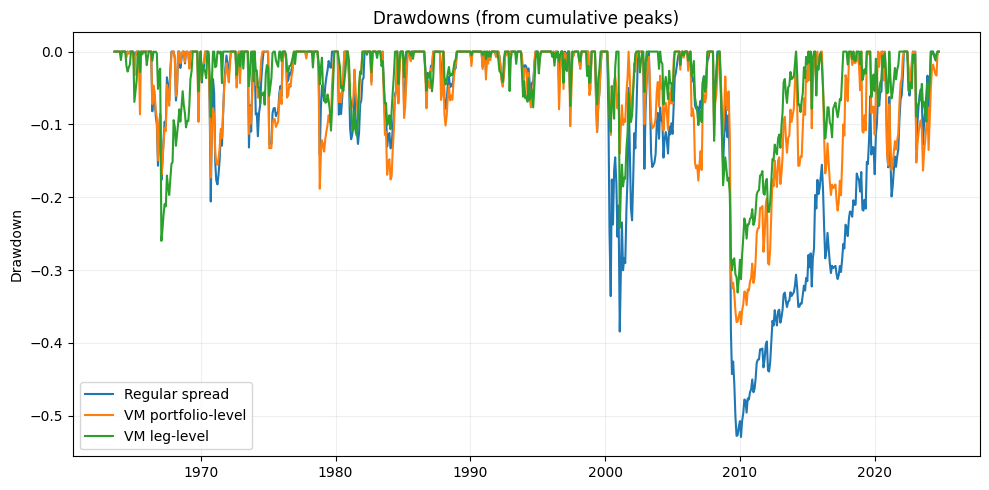

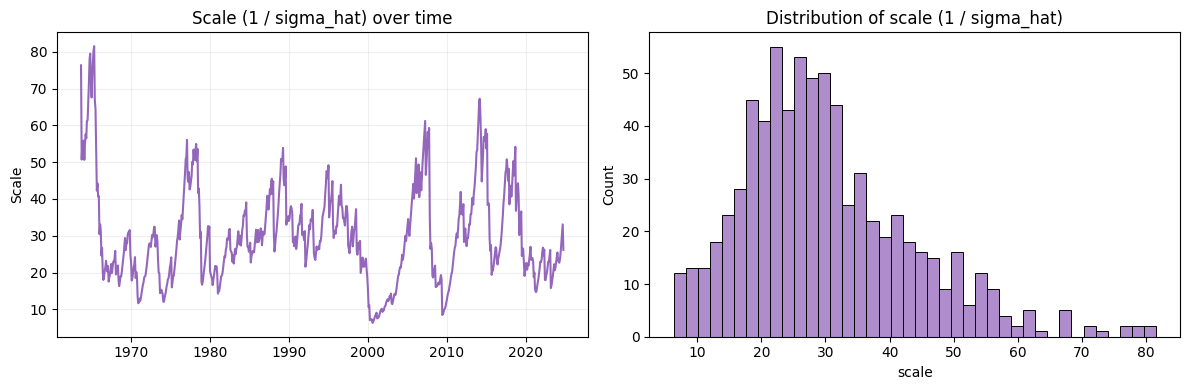

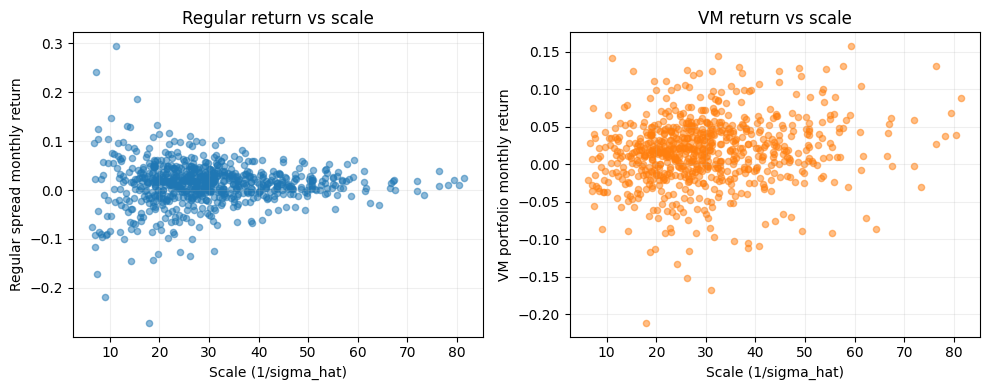

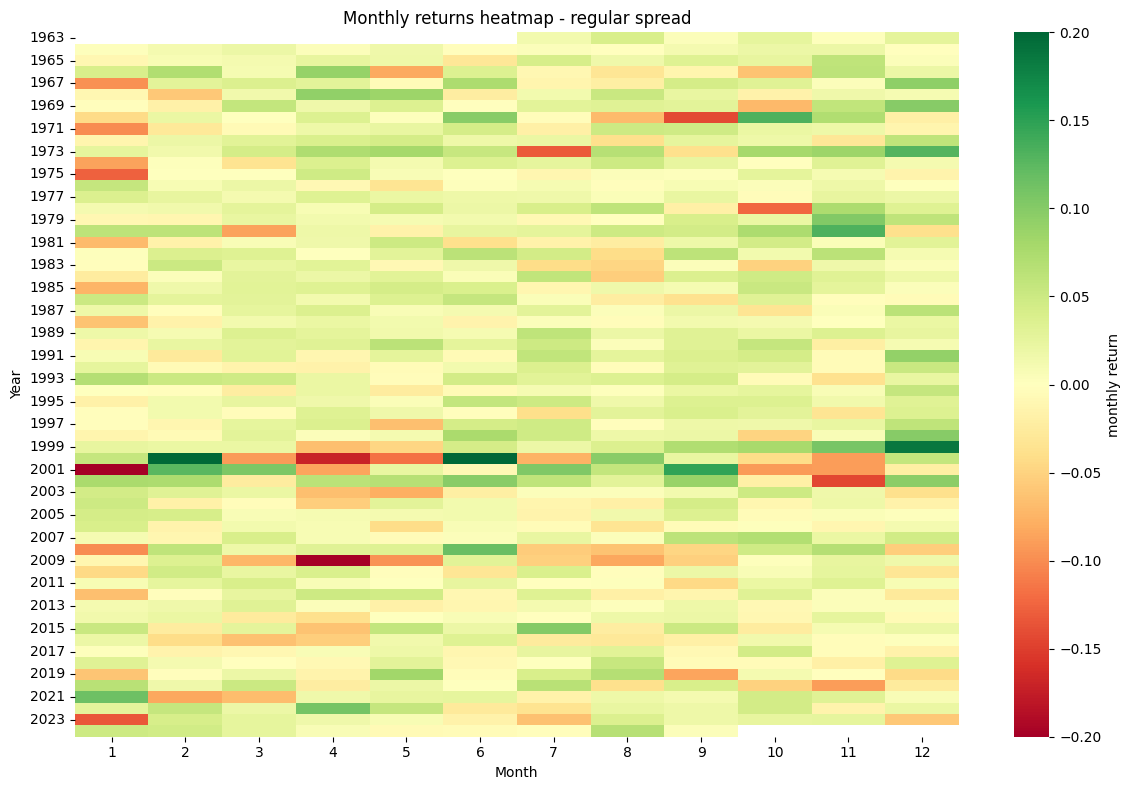

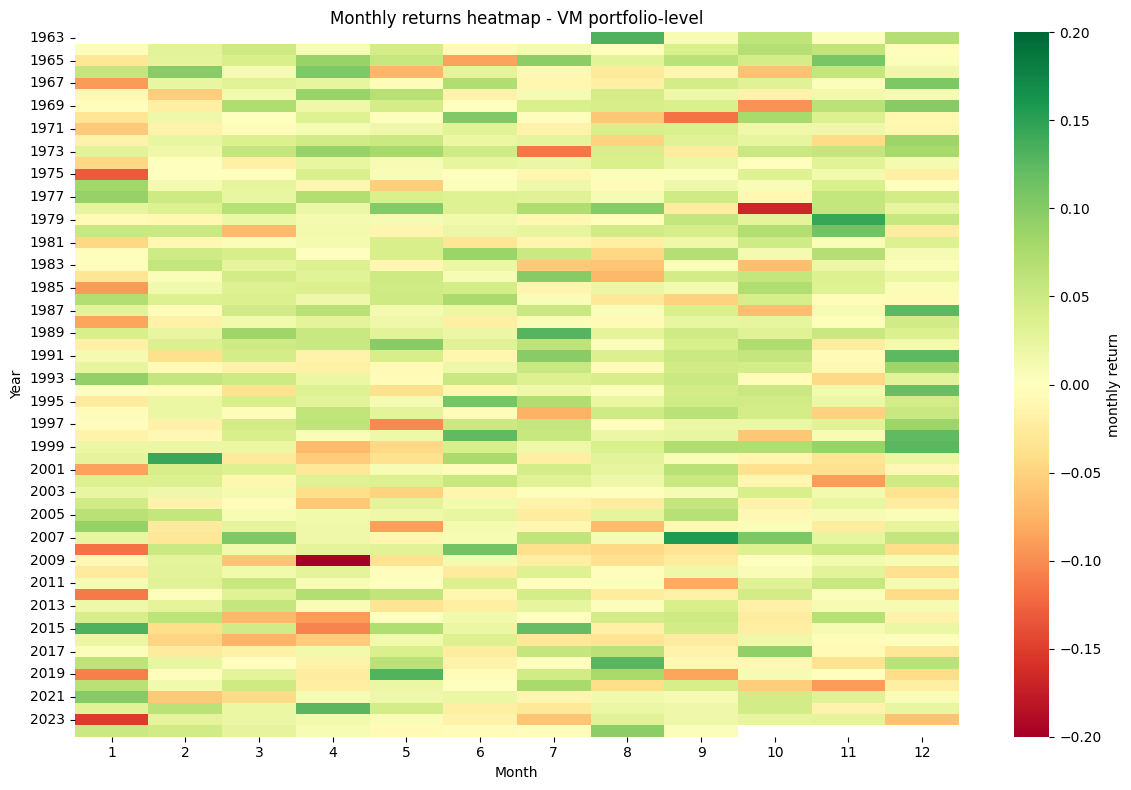

              ann_mean  ann_vol  ann_sharpe  max_drawdown
regular         0.1426    0.157      0.9078       -0.5293
vm_portfolio    0.1941    0.157      1.2361       -0.3743
vm_leg          0.1509    0.157      0.9606       -0.3309


In [12]:
# Plots for comparing regular vs volatility-managed momentum
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Ensure expected series exist
for name in ['spread','vm_portfolio','vm_leg','sigma_hat']:
    if name not in globals():
        raise RuntimeError(f"Required series '{name}' not found in the notebook namespace.")

# Align series and drop NaNs for plotting comparisons
data = pd.DataFrame({
    'spread': spread,
    'vm_portfolio': vm_portfolio,
    'vm_leg': vm_leg,
    'scale': (1.0 / sigma_hat).replace([np.inf, -np.inf], np.nan)
}).dropna(how='all').sort_index()

# Helper transforms
monthly_to_annual = np.sqrt(12)
def ann_mean(sr): return sr.mean() * 12
def ann_vol(sr): return sr.std() * monthly_to_annual
def rolling_ann_sharpe(sr, window=12, rf=0.0002):
    roll_mean = sr.rolling(window).mean() * 12
    roll_std = sr.rolling(window).std() * monthly_to_annual
    return (roll_mean - rf*12) / roll_std

# 1) Cumulative returns (line)
cum = (1 + data[['spread','vm_portfolio','vm_leg']]).cumprod() - 1
plt.figure(figsize=(10,5))
plt.plot(cum.index, np.log1p(cum['spread']), label='Regular spread', linewidth=1.5)
plt.plot(cum.index, np.log1p(cum['vm_portfolio']), label='VM portfolio-level', linewidth=1.5)
plt.plot(cum.index, np.log1p(cum['vm_leg']), label='VM leg-level', linewidth=1.5)
plt.legend()
plt.title('Cumulative returns (monthly)')
plt.ylabel('Cumulative return')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 2) Rolling annualized Sharpe (12-month)
plt.figure(figsize=(10,4))
rs_sp = rolling_ann_sharpe(data['spread'])
rs_vm = rolling_ann_sharpe(data['vm_portfolio'])
rs_leg = rolling_ann_sharpe(data['vm_leg'])
plt.plot(rs_sp.index, rs_sp, label='Regular spread', alpha=0.9)
plt.plot(rs_vm.index, rs_vm, label='VM portfolio-level', alpha=0.9)
plt.plot(rs_leg.index, rs_leg, label='VM leg-level', alpha=0.9)
plt.axhline(0, color='k', linewidth=0.5)
plt.legend()
plt.title('Rolling 12-month annualized Sharpe')
plt.ylabel('Sharpe')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 3) Rolling annualized volatility (12-month)
plt.figure(figsize=(10,4))
rv_sp = data['spread'].rolling(12).std() * monthly_to_annual
rv_vm = data['vm_portfolio'].rolling(12).std() * monthly_to_annual
rv_leg = data['vm_leg'].rolling(12).std() * monthly_to_annual
plt.plot(rv_sp.index, rv_sp, label='Regular spread', alpha=0.9)
plt.plot(rv_vm.index, rv_vm, label='VM portfolio-level', alpha=0.9)
plt.plot(rv_leg.index, rv_leg, label='VM leg-level', alpha=0.9)
plt.legend()
plt.title('Rolling 12-month annualized volatility')
plt.ylabel('Annualized volatility')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 4) Maximum drawdown curves
def drawdown(series):
    cum = (1+series).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1
    return dd
dd_sp = drawdown(data['spread'])
dd_vm = drawdown(data['vm_portfolio'])
dd_leg = drawdown(data['vm_leg'])
plt.figure(figsize=(10,5))
plt.plot(dd_sp.index, dd_sp, label='Regular spread')
plt.plot(dd_vm.index, dd_vm, label='VM portfolio-level')
plt.plot(dd_leg.index, dd_leg, label='VM leg-level')
plt.legend()
plt.title('Drawdowns (from cumulative peaks)')
plt.ylabel('Drawdown')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 5) Scale time series (1/sigma_hat) and its histogram
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(data['scale'].index, data['scale'], color='tab:purple')
axs[0].set_title('Scale (1 / sigma_hat) over time')
axs[0].set_ylabel('Scale')
axs[0].grid(alpha=0.2)
sns.histplot(data['scale'].dropna(), bins=40, ax=axs[1], color='tab:purple')
axs[1].set_title('Distribution of scale (1 / sigma_hat)')
plt.tight_layout()
plt.show()

# 6) Scatter: monthly returns vs scale for portfolio-level VM and regular spread
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(data['scale'], data['spread'], alpha=0.5, s=20)
plt.xlabel('Scale (1/sigma_hat)')
plt.ylabel('Regular spread monthly return')
plt.title('Regular return vs scale')
plt.grid(alpha=0.2)

plt.subplot(1,2,2)
plt.scatter(data['scale'], data['vm_portfolio'], alpha=0.5, s=20, color='tab:orange')
plt.xlabel('Scale (1/sigma_hat)')
plt.ylabel('VM portfolio monthly return')
plt.title('VM return vs scale')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 7) Monthly heatmap of returns (years on y, months on x) for quick seasonal/time visualization
def monthly_heatmap(series, title):
    s = series.dropna().copy()
    s = s.to_frame('r')
    s['year'] = s.index.year
    s['month'] = s.index.month
    pivot = s.pivot_table(index='year', columns='month', values='r', aggfunc='mean')
    plt.figure(figsize=(12,8))
    sns.heatmap(pivot, cmap='RdYlGn', center=0, vmin=-0.2, vmax=0.2, cbar_kws={'label':'monthly return'})
    plt.title(title)
    plt.ylabel('Year')
    plt.xlabel('Month')
    plt.tight_layout()
    plt.show()

monthly_heatmap(data['spread'], 'Monthly returns heatmap - regular spread')
monthly_heatmap(data['vm_portfolio'], 'Monthly returns heatmap - VM portfolio-level')

# 8) Summary table printed: annualized mean, vol, Sharpe, max drawdown
summary = pd.DataFrame(index=['regular','vm_portfolio','vm_leg'])
summary['ann_mean'] = [ann_mean(data['spread'].dropna()), ann_mean(data['vm_portfolio'].dropna()), ann_mean(data['vm_leg'].dropna())]
summary['ann_vol'] = [ann_vol(data['spread'].dropna()), ann_vol(data['vm_portfolio'].dropna()), ann_vol(data['vm_leg'].dropna())]
summary['ann_sharpe'] = summary['ann_mean'] / summary['ann_vol']
summary['max_drawdown'] = [dd_sp.min(), dd_vm.min(), dd_leg.min()]
print(summary.round(4))


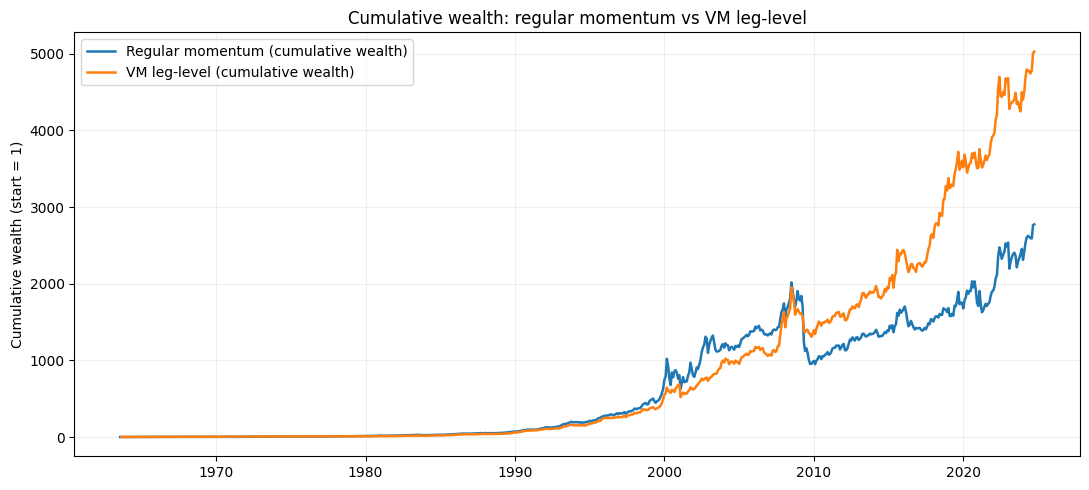

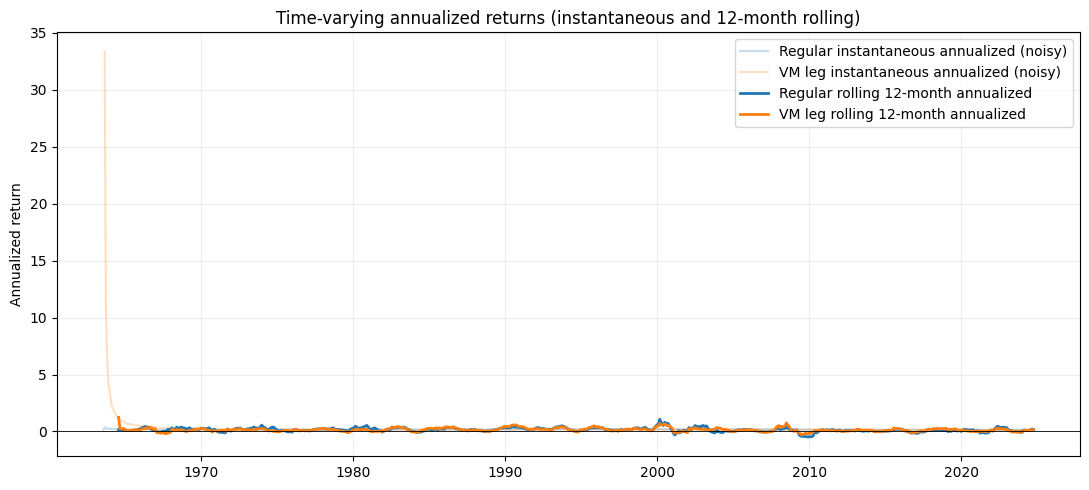

Endpoint annualized metrics:
 Regular momentum  : annual return 13.819%, ann vol 15.70%, ann Sharpe 0.880
 VM leg-level      : annual return 14.951%, ann vol 15.70%, ann Sharpe 0.952


In [13]:
# Cumulative and annualized-equivalent cumulative plot for regular momentum vs VM leg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Check series exist
for name in ['spread','vm_leg']:
    if name not in globals():
        raise RuntimeError(f"Required series '{name}' not found in the notebook namespace.")

# Align and drop NaNs
data = pd.DataFrame({
    'regular': spread,
    'vm_leg': vm_leg
}).sort_index().dropna(how='all')

# compute cumulative wealth (start at 1)
cum = (1 + data).cumprod()

# compute time (months elapsed) since start for each index
months_elapsed = np.arange(1, len(cum) + 1)

# compute annualized "equivalent" cumulative return at each date:
# annualized_return_t = (cum_t)^(12 / months_elapsed_t) - 1
# then convert back to an annualized cumulative wealth path for plotting:
# ann_equiv_wealth_t = (1 + annualized_return_t) ** (months_elapsed_t / 12)
# Note: the ann_equiv_wealth equals cum itself by algebra, but we compute the
# instantaneous annualized return series and plot it on a secondary axis for clarity.
ann_ret = (cum ** (12 / months_elapsed.reshape(-1,1))) - 1  # DataFrame broadcast
ann_ret = ann_ret.set_index(cum.index)

# Rolling annualized return (12-month window) for smoother time-varying annualized performance
rolling_ann = (data.rolling(window=12).apply(lambda x: (np.prod(1 + x) ** (12 / len(x)) - 1), raw=False)).dropna()

# Plot 1: cumulative wealth (linear scale)
plt.figure(figsize=(11,5))
plt.plot(cum.index, cum['regular'], label='Regular momentum (cumulative wealth)', linewidth=1.8)
plt.plot(cum.index, cum['vm_leg'], label='VM leg-level (cumulative wealth)', linewidth=1.8)
plt.title('Cumulative wealth: regular momentum vs VM leg-level')
plt.ylabel('Cumulative wealth (start = 1)')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Plot 2: instantaneous annualized return series (noisy) and smoothed rolling annualized return
plt.figure(figsize=(11,5))
plt.plot(ann_ret.index, ann_ret['regular'], color='C0', alpha=0.25, label='Regular instantaneous annualized (noisy)')
plt.plot(ann_ret.index, ann_ret['vm_leg'], color='C1', alpha=0.25, label='VM leg instantaneous annualized (noisy)')
plt.plot(rolling_ann.index, rolling_ann['regular'], color='C0', linewidth=2.0, label='Regular rolling 12-month annualized')
plt.plot(rolling_ann.index, rolling_ann['vm_leg'], color='C1', linewidth=2.0, label='VM leg rolling 12-month annualized')
plt.axhline(0, color='k', linewidth=0.6)
plt.title('Time-varying annualized returns (instantaneous and 12-month rolling)')
plt.ylabel('Annualized return')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Optional: print endpoint annualized metrics
def ann_stats(series):
    n = series.dropna().shape[0]
    total_mult = (1 + series.dropna()).prod()
    ann_return = total_mult ** (12 / n) - 1
    ann_vol = series.std() * np.sqrt(12)
    ann_sharpe = ann_return / ann_vol if ann_vol>0 else np.nan
    return ann_return, ann_vol, ann_sharpe

r_ann = ann_stats(data['regular'])
vm_ann = ann_stats(data['vm_leg'])
print("Endpoint annualized metrics:")
print(f" Regular momentum  : annual return {r_ann[0]:.3%}, ann vol {r_ann[1]:.2%}, ann Sharpe {r_ann[2]:.3f}")
print(f" VM leg-level      : annual return {vm_ann[0]:.3%}, ann vol {vm_ann[1]:.2%}, ann Sharpe {vm_ann[2]:.3f}")
